# Your work here!

In [101]:
import numpy as np 
import pandas as pd

import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader
!pwd
N = 96 
nEpochs = 100
FIRSTRUN = False
GPU  = torch.device('cuda:0') 

/home/irina/Hackathon/environmental-hackathon


In [92]:
train_red = np.load("data/train_data_reduced.npy")
train_red.shape

(20007, 960)

In [93]:
test_red = np.load("data/test_data_reduced.npy")
test_red.shape

(9898, 960)

In [95]:
inputDimensionality = N
model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//8), nn.Sigmoid(),
    nn.Linear(inputDimensionality//8, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)                )

In [96]:
from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

1
12096


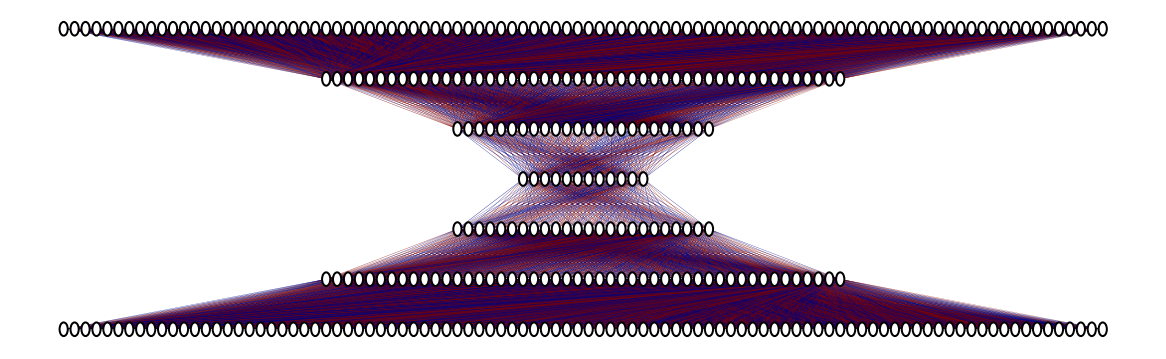

In [97]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model, ax)
plt.axis('tight'); plt.axis('off'); plt.show()


In [98]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU
anom1 = np.load("anom1.npy")

In [125]:
def train_model ( model, dataLoader, nEpochs = 10 ):

    model = model.to(GPU)
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
       #     print(iEpoch, i, iInputBatch.shape, iInputBatch[0,20])
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
        #print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

def evaluate_model (model, dataLoader, nEvals = 1000):
    mse_errors = []
    test_iterator = iter(dataLoader)
    for iSample in range(nEvals):
        try:
            sample = next(test_iterator)[0]
        except StopIteration:
            test_iterator = iter(dataLoader) # create an object of class _DataLoaderIter
            sample = next(test_iterator)[0]

        reconstruction = model.forward(sample.to(GPU))
        
        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        mse = (np.square(reconstructionNumpy - sampleNumpy)).mean(axis=None)
        mse_errors.append(mse) 
    return mse_errors

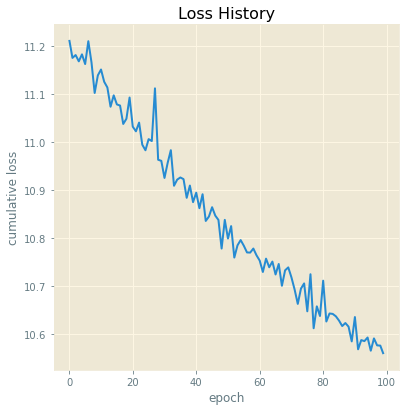

In [126]:
train_co2 = train_red[:, :N]
test_co2 = test_red[:, :N]
DL_Train_co2 = DataLoader(train_co2.astype('float32'), batch_size=16, shuffle = True )
DL_Test_co2  = DataLoader( test_co2.astype('float32'), batch_size=1 , shuffle = False)

#startTime = time.time()
if FIRSTRUN: 
    model_co2, loss_co2 = train_model( model, DL_Train_co2, 20)
else:
    model_co2 = torch.load("model_co2.v1.pth", map_location=GPU)
model_co2, loss_co2 = train_model( model_co2, DL_Train_co2, nEpochs)
torch.save( model_co2, "model_co2.v1.pth")
#print('elapsed time : {} '.format(time.time() - startTime))

plt.figure(figsize=(6,6));
plt.plot(loss_co2)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


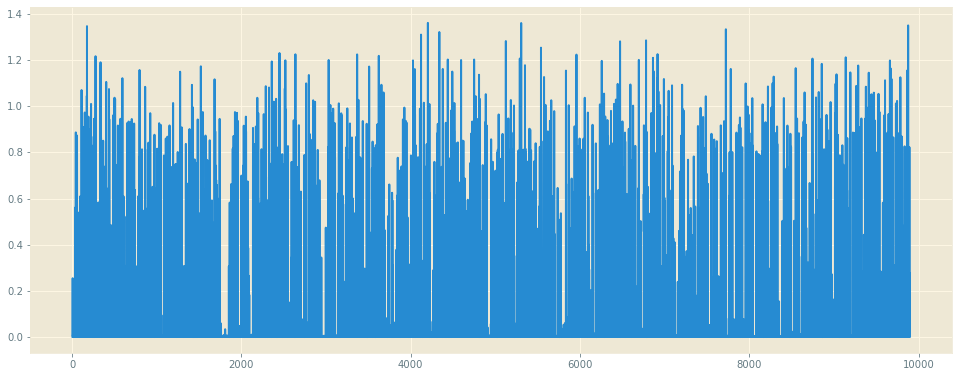

In [127]:
model_co2 = torch.load("model_co2.v1.pth", map_location=GPU)
mse_errors_co2 = evaluate_model( model_co2, DL_Test_co2, len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_co2)
#plt.plot(int(anom1), mse_errors_co2[anom1], "ro")

In [128]:
#plt.figure(figsize=(16,6));
#plt.plot(mse_errors_co2)
#plt.plot(anom1, mse_errors_co2[anom1][indices.astype(int)], "ro")


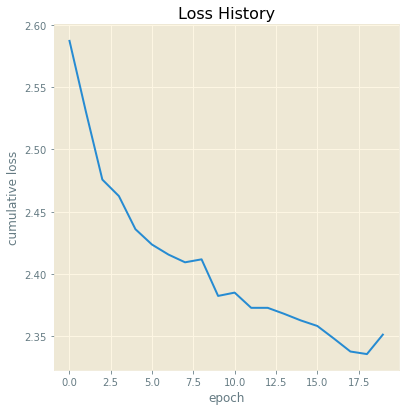

In [129]:
train_tem = train_red[:, N: N*2]
test_tem  =  test_red[:, N: N*2]
DL_Train_tem = DataLoader(train_tem.astype('float32'), batch_size=16, shuffle = True )
DL_Test_tem  = DataLoader( test_tem.astype('float32'), batch_size=1 , shuffle = False )

if FIRSTRUN: 
    model_tem, loss_tem = train_model( model, DL_Train_tem, 20)
else:
    model_tem = torch.load("model_tem.v1.pth", map_location=GPU)

model_tem, loss_tem = train_model( model_tem, DL_Train_tem, nEpochs)
torch.save( model_tem, "model_tem.v1.pth")

plt.figure(figsize=(6,6));
plt.plot(loss_temp)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

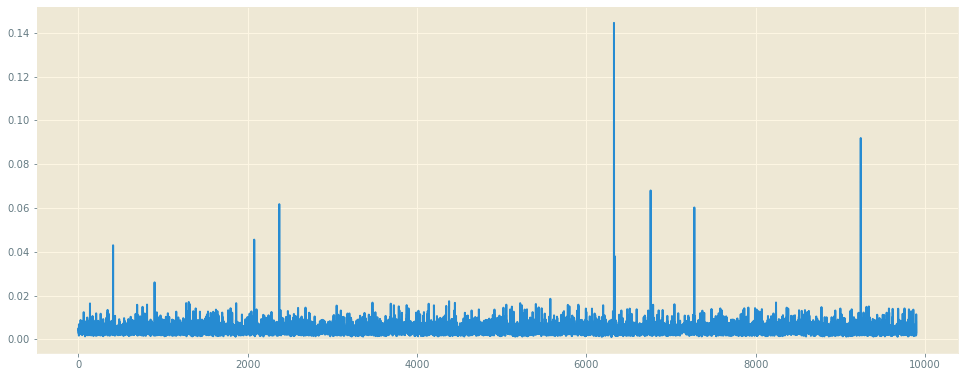

In [130]:
model_tem = torch.load("model_tem.v1.pth", map_location=GPU)
mse_errors_tem = evaluate_model( model_tem, DL_Test_tem, len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_tem)
#plt.plot(anom1, mse_errors_tem[anom1], "ro")

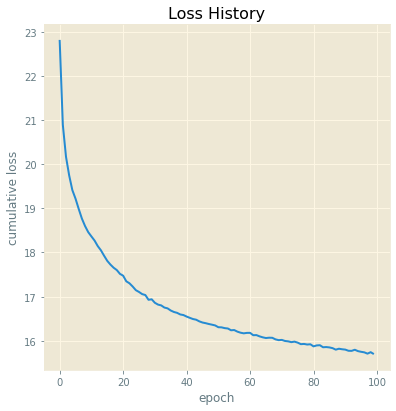

In [131]:
train_dew = train_red[:, N*2: N*3]
test_dew  =  test_red[:, N*2: N*3]
DL_Train_dew = DataLoader(train_dew.astype('float32'), batch_size=16, shuffle = True )
DL_Test_dew  = DataLoader( test_dew.astype('float32'), batch_size=1 , shuffle = False)

if FIRSTRUN: 
    model_dew, _ = train_model( model, DL_Train_dew, 20)
else:
    model_dew = torch.load("model_dew.v1.pth", map_location=GPU)

model_dew, loss_dew = train_model(model_dew, DL_Train_dew, nEpochs)
torch.save(model_dew, "model_dew.v1.pth")

plt.figure(figsize=(6,6));
plt.plot(loss_dew)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

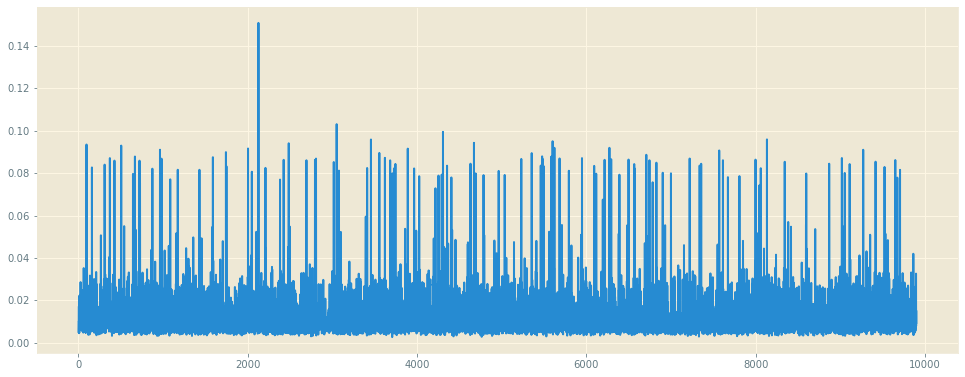

In [132]:
model_dew = torch.load("model_dew.v1.pth", map_location=GPU)
mse_errors_dew = evaluate_model(model_dew, DL_Test_dew,len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_dew)

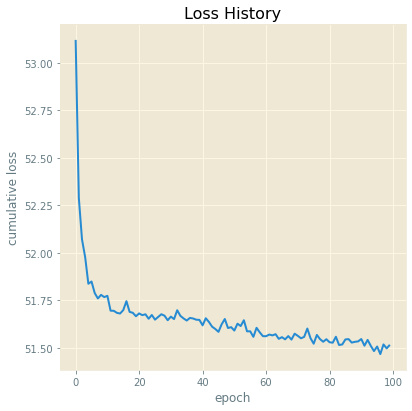

In [133]:
train_hum = train_red[:, N*3: N*4]
test_hum  = test_red[:,  N*3: N*4]
DL_Train_hum = DataLoader(train_hum.astype('float32'), batch_size=16, shuffle = True )
DL_Test_hum  = DataLoader( test_hum.astype('float32'), batch_size=1 , shuffle = False )

if FIRSTRUN: 
    model_hum, _ = train_model(model, DL_Train_hum, 20)
else:
    model_hum = torch.load("model_hum.v1.pth", map_location=GPU)

model_hum, loss_hum = train_model(model_hum, DL_Train_hum, nEpochs)
torch.save(model_hum, "model_hum.v1.pth")

plt.figure(figsize=(6,6));
plt.plot(loss_hum)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

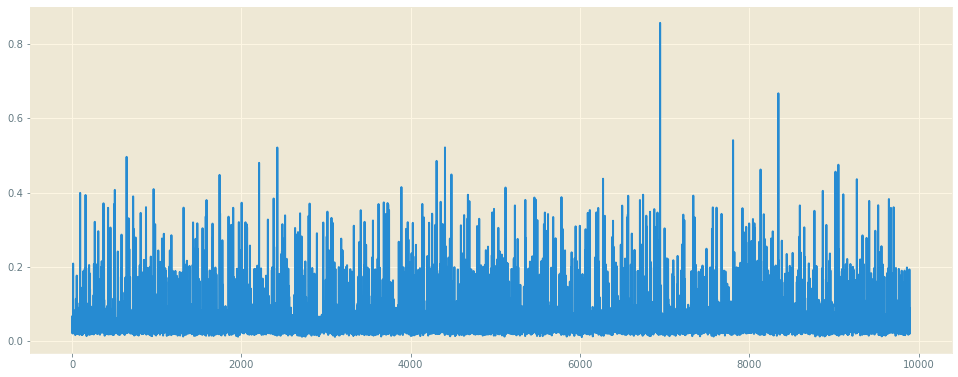

In [134]:
model_hum = torch.load("model_hum.v1.pth", map_location=GPU)
mse_errors_hum = evaluate_model(model_hum, DL_Test_hum, len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_hum)